In [1]:
#### Um programa para série temporal de CHL from CMEMS 

# Libray

import numpy as np
import xarray as xr 

import matplotlib.pyplot as plt
import cmocean as cmo

from mpl_toolkits.basemap import Basemap
from matplotlib import rc
from scipy.signal import oaconvolve
from gsw import distance
from scipy.interpolate import interp1d as i1d

# Params plot

plt.rcParams['font.size']=13
plt.rcParams['font.sans-serif']='Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.weight']='bold'


In [2]:
# -----------------------------------------------------------------------------
def gauss(nx, nt, s):
    ''' g, x0, y0 = gauss(nx, nt, s)
        Returns g, a 2D Gaussian kernel with nx columns and nt rows; s is
        the standard deviation and thus controls the shape of the curve.
        nx and nt should be odd integers. Returns also the x0, y0
        pixel grid space'''
    nx = int(nx)
    if np.mod(nx, 2) == 0:
        nx += 1
    nt = int(nt)
    if np.mod(nt, 2) == 0:
        nt += 1
    # create a mesh of shape (v,h)
    x0, y0 = np.meshgrid(np.linspace(0.5, nx-0.5, num=nx),
                         np.linspace(0.5, nt-0.5, num=nt))
    g = np.exp(-0.5*((np.pi*(x0-nx/2)/(nx*s))**2 +
                     (np.pi*(y0-nt/2)/(nt*s))**2)) /\
        (np.sqrt(2*np.pi) * s)
    # sum should be one, there are no negative values
    g = g-g.min()
    g = g/g.sum()
    return g, x0, y0
# -----------------------------------------------------------------------------------------------

def obconvolve(z, f):
    ''' obconvolve(z,f) one-liner based on scipy.signal.oaconvolve
    Returns z1 which is the  result of the convolution of z and f, with borders
    rectified by dividing z by the convolution of a unitary matrix shaped as z
    with the kernel f. Mode='same' is hardwired.
    '''
    z0 = oaconvolve(z, f, mode='same') /        oaconvolve(np.ones(z.shape), np.abs(f), mode='same')
    return z0
# -----------------------------------------------------------------------------------------------


In [3]:
# building dataset and variables

data = xr.open_dataset('/home/bruno/git/CMEMS/chla_data/CHL-GLO-L4.nc') #serie cmems monthly composite
print('Geral do arquivo')
print(data.variables.keys())
data.close()

time=data['time'][:].data #variável tempo
print(time)

Geral do arquivo
KeysView(Frozen({'CHL': <xarray.Variable (time: 216, latitude: 457, longitude: 481)>
[47480472 values with dtype=float32]
Attributes:
    long_name:          Chlorophyll-a concentration in seawater (not log-tran...
    units:              milligram m-3
    grid_mapping:       grid_mapping
    standard_name:      mass_concentration_of_chlorophyll_a_in_sea_water
    units_nonstandard:  mg m^-3
    type:               surface
    source:             Aqua,Suomi-NPP-MODISA,VIIRSN-L3
    valid_min:          0.01
    valid_max:          66.83439
    cell_methods:       time: mean
    _ChunkSizes:        [  1 256 256], 'time': <xarray.IndexVariable 'time' (time: 216)>
array(['2002-01-01T00:00:00.000000000', '2002-02-01T00:00:00.000000000',
       '2002-03-01T00:00:00.000000000', ..., '2019-10-01T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Attributes:
    valid_min:            0
    long_name:     

In [4]:
s_data = data.groupby("time.season").mean() 

s_file=s_data.reindex()

s_data.close()

/home/bruno/anaconda2/envs/ocean/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


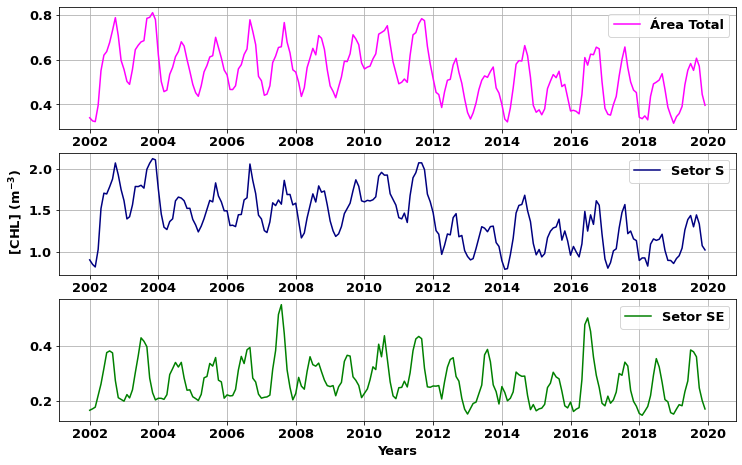

In [5]:
# series

serie_SS1 = data.CHL.mean(('latitude','longitude'))

## Subset 1 

data_SS2 = data.isel(latitude = (data.latitude > -39) & (data.latitude < -30),  
                     longitude = (data.longitude < -49) & (data.longitude > -59)) 

serie_SS2 = data_SS2.CHL.mean(('latitude','longitude'))

## Subset 2

data_SS3 = data.isel(latitude = (data.latitude > -30) & (data.latitude < -21), 
                     longitude = (data.longitude < -39) & (data.longitude > -50)) 

serie_SS3 = data_SS3.CHL.mean(('latitude', 'longitude'))

#### time mean

data_ymean = data.CHL.mean('time')

data_ymean_2 = data_SS2.CHL.mean('time')

data_ymean_3 = data_SS3.CHL.mean('time') 

'''
Series plot 
'''

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12.13,  7.61)) # Linhas X Colunas

ax1.plot(time,serie_SS1,color='magenta',label='Área Total')
ax1.grid()
ax1.legend()

ax2.plot(time,serie_SS2,color='navy',label='Setor S')
ax2.grid()
ax2.set_ylabel(r' [CHL] (m$^{-3}$)',weight='bold')
ax2.legend()

ax3.plot(time,serie_SS3,color='green',label='Setor SE')
ax3.grid()
ax3.set_xlabel('Years',weight='bold')
ax3.legend()

Text(0.5, 1.0, 'Seasonal CHL distribution')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


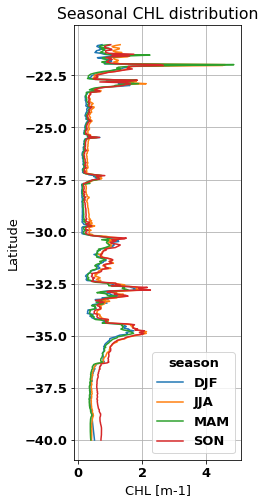

In [6]:
###### SEASON PLOT

plt.figure(figsize = (3, 8))
s_file.CHL.mean("longitude").plot.line(hue="season", y="latitude")
plt.grid(True)
plt.ylabel('Latitude')
plt.xlabel('CHL [m-1]')
plt.title('Seasonal CHL distribution')

/home/bruno/anaconda2/envs/ocean/lib/python3.6/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':


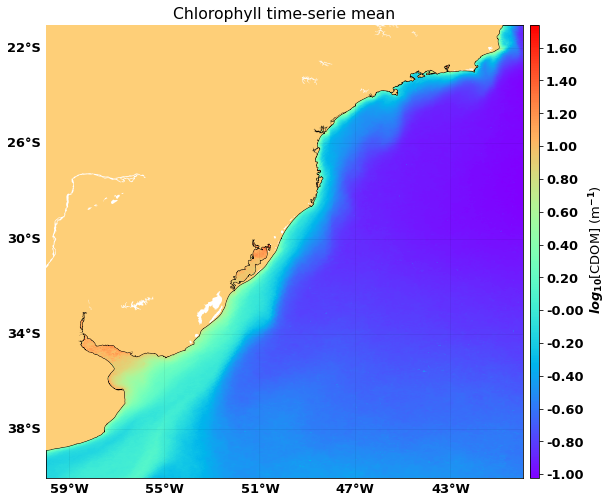

In [23]:
#### PLOT AREA ####

lon=data.longitude
lat=data.latitude

lon, lat = np.meshgrid(lon,lat)

p=plt.figure(figsize=(10.28,  7.17))
lbs=[True, False,False,True]

ltmn=lat.min();lnmn=lon.min();ltmx=lat.max();lnmx=lon.max()
C = Basemap(llcrnrlon=lnmn,llcrnrlat=ltmn,urcrnrlat=ltmx,urcrnrlon=lnmx,resolution='h',projection='cyl')

C.drawcoastlines(linewidth=1);
C.fillcontinents(color='#fecf78',zorder=100)
C.drawmeridians(np.arange(-59,-39,4),labels=lbs,linewidth=0.1)
C.drawparallels(np.arange(-39+1,-20,4),labels=lbs,linewidth=0.1)

cc=C.pcolormesh(lon, lat, np.log10(data.CHL.mean('time')), cmap='rainbow')#, extend='max')

cbar=plt.colorbar(cc,ticks=np.arange(-1,2,0.2),format='%.2f',aspect=50,pad=0.01)
cbar.set_label(r' $log_{10}$[CDOM] (m$^{-1}$)')
plt.title('Chlorophyll time-serie mean')

plt.tight_layout()


Text(0.5, 1.0, '(Diagrama de Hovmoller- 25 $^o$S)')

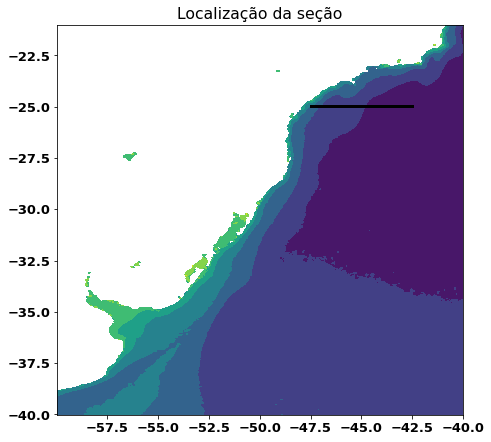

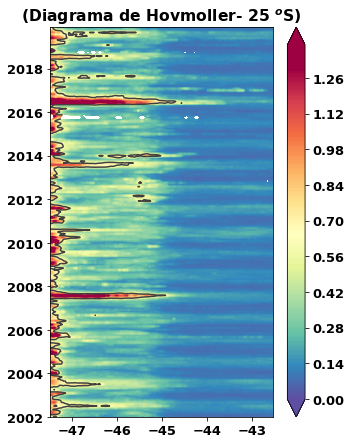

In [25]:
ilat=np.argwhere(lat[:,0]>=-25).T[0]
ilat=ilat[-1] #achando o indices de lat que quero usar para o hovmoller

ilon=np.argwhere((lon[0,:]>=-47.5)&(lon[0,:]<=-42.5)).T[0]

'Linha no mapa'
p=plt.figure(figsize=(7.28,  7.17))
plt.contourf(lon,lat,np.log10(data_ymean))
plt.plot(lon[ilat,ilon],lat[ilat,ilon],'k',linewidth=3)
plt.title('Localização da seção')

'Hovmoller'
hchla=data.CHL[:,ilat,ilon] #todos os tempos, uma lat e um intervalo de lon

'Plotando'
p=plt.figure(figsize=(5,  7.17))
plt.contourf(lon[ilat,ilon],time,hchla,vmin=0.0,vmax=1.3,levels=np.arange(0,1.4,0.01),
             extend='both',cmap='Spectral_r')
plt.colorbar()
plt.contour(lon[ilat,ilon],time,hchla,levels=[0.60],colors='0.25')
plt.title(r'(Diagrama de Hovmoller- 25 $^o$S)',weight='bold')